In [1]:
# !python -m spacy download nl_core_news_sm

In [2]:
import pandas as pd
import numpy as np
import string
import re

from datasets import Dataset, load_metric
from transformers import DataCollatorForTokenClassification, pipeline, AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments, TrainerCallback

import torch

import spacy
from spacy import displacy

import os
from datetime import datetime
import json

from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import pickle


C:\Users\niels\miniconda3\envs\BookReviewsThesis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from loss_functions import DiceLoss, MoMLoss

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
# Load an Excel file into a DataFrame
df = pd.read_excel('manullay_check_partially_matched_titles.xlsx', engine='openpyxl')
# df = pd.read_excel('LCReviewsIntegrated_1962-1994.xlsx', engine='openpyxl')

In [6]:
def remove_extra_spaces(text):
    # Replace multiple spaces with a single space
    cleaned_text = re.sub(r'\s+', ' ', text)
    return cleaned_text.strip()

In [7]:
df['content'] = df['content'].apply(remove_extra_spaces)
df['title1'] = df['title1'].apply(remove_extra_spaces)
df['title4'] = df['title4'].apply(remove_extra_spaces)

In [8]:
def remove_punctuation(input_string):
    # Adding old Dutch quotation marks to the punctuation list
    extended_punctuation = string.punctuation + '„“'
    # Create a translation table that maps each punctuation character to None
    translator = str.maketrans('', '', extended_punctuation)
    # Translate the input string using the translation table
    return input_string.translate(translator)

In [9]:
# First, filter rows where 'manually_removed' is 1 and get unique 'content' values in these rows
content_removed = df[df['manually_removed'] == 1]['content'].unique()

# Now, filter out these 'content' values from the main DataFrame and find unique 'content' not removed
df_clean = df[~df['content'].isin(content_removed)]

## Preprare for training

In [10]:
# model_checkpoint = "distilbert-base-uncased"

model_checkpoint = "Babelscape/wikineural-multilingual-ner"   # BEST F1 0.65

# TO USE:
# model_checkpoint = "FacebookAI/xlm-roberta-large-finetuned-conll03-english"
# model_checkpoint = "pdelobelle/robbert-v2-dutch-ner"
# model_checkpoint = "GroNLP/bert-base-dutch-cased"   # BEST F1 0.59
# model_checkpoint = "pdelobelle/robbert-v2-dutch-base"

In [11]:
label_list = ['O', 'I']

In [12]:
def find_sentence_in_text(full_text, sentence):
    start_index = full_text.find(sentence)
    if start_index == -1:
        raise ValueError("Sentence not found in text.")
    end_index = start_index + len(sentence)
    return start_index, end_index


def create_mask_for_sentence(full_text, sentence, nlp, force_lower_case=False):
    # Use the already loaded nlp model to process the text
    doc = nlp(full_text)
    start_index, end_index = find_sentence_in_text(full_text.lower(), sentence.lower())
    if start_index is None:
        return None, None
    if force_lower_case:
        tokens = [token.text.lower() for token in doc]
    else:
        tokens = [token.text for token in doc]
    mask = [0] * len(doc)

    for i, token in enumerate(doc):
        token_end_idx = token.idx + len(token.text)
        if token.idx <= end_index and token_end_idx >= start_index:
            mask[i] = 1

    return tokens, mask


def create_data_set(samples, df, nlp, remove_punc=False, force_lower_case=False):
    data = []
    for sample in tqdm(samples):
        unique_content_df = df[df['content'] == sample]
        masks = []

        if remove_punc:
            review = remove_punctuation(sample)
        else:
            review = sample
        
        for _, row in unique_content_df.iterrows():
            if remove_punc:
                book = remove_punctuation(row['title4'])
            else:
                book = row['title4']
                
            tokens, mask = create_mask_for_sentence(full_text=review, sentence=book, nlp=nlp, force_lower_case=force_lower_case) 
            if mask is not None:
                masks.append(mask)

        if masks:
            combined_mask = np.bitwise_or.reduce(np.array(masks), axis=0)
            data.append({"tokens": tokens, "ner_tags": combined_mask})

    return data

In [13]:
nlp = spacy.load("nl_core_news_sm")

In [14]:
remove_punc = False
force_lower_case = False

In [15]:
train_filename = 'C:/Users/niels/PycharmProjects/BookReviewsThesis/dataset/train_dataset.pkl'
val_filename = 'C:/Users/niels/PycharmProjects/BookReviewsThesis/dataset/val_dataset.pkl'

In [16]:
# Function to save dataset to file
def save_dataset(dataset, filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)  # Ensure the directory exists
    with open(filename, 'wb') as f:
        pickle.dump(dataset, f)

# Function to load dataset from file
def load_dataset(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [17]:
# Set the random seed for reproducibility
np.random.seed(42)

# Shuffle the unique samples
samples = df_clean['content'].unique()
np.random.shuffle(samples)

# Calculate the split index
split_idx = int(len(samples) * 0.85)

# Split the samples into training and validation sets
train_samples = samples[:split_idx]
val_samples = samples[split_idx:]

if os.path.exists(train_filename) and os.path.exists(val_filename):
    print("Loading training and validation datasets....")
    train_dataset = load_dataset(train_filename)
    val_dataset = load_dataset(val_filename)
else:
    print("Creating training and validation datasets....")
    # Create dataset
    train_dataset = Dataset.from_list(create_data_set(samples=train_samples, df=df_clean, nlp=nlp, remove_punc=remove_punc, force_lower_case=force_lower_case))
    val_dataset = Dataset.from_list(create_data_set(samples=val_samples, df=df_clean, nlp=nlp, remove_punc=remove_punc, force_lower_case=force_lower_case))

    # Save dataset, so we don't have to create it everytime again
    save_dataset(train_dataset, train_filename)
    save_dataset(val_dataset, val_filename)

print("Done...")

Creating training and validation datasets....


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1881/1881 [02:59<00:00, 10.50it/s]


Done...


In [18]:
train_dataset

Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 10654
})

In [19]:
val_dataset

Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 1881
})

In [20]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [21]:
label_all_tokens = True

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [22]:
tokenized_dataset_train = train_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_dataset_val = val_dataset.map(tokenize_and_align_labels, batched=True)

tokenized_dataset_train

Map: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1881/1881 [00:03<00:00, 525.05 examples/s]


Dataset({
    features: ['tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 10654
})

In [23]:
metric = load_metric("seqeval")

def compute_metrics(p): 
    logits, labels = p
    predictions = np.argmax(logits, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)
    ]

    total_count_O = 0
    total_count_I = 0
    for pred in true_predictions:
        total_count_O = total_count_O + sum(s.count("O") for s in pred)
        total_count_I = total_count_I + sum(s.count("I") for s in pred)
        
    # Flatten the lists to enable macro F1 calculation using sklearn
    flat_predictions = [label for sublist in true_predictions for label in sublist]
    flat_labels = [label for sublist in true_labels for label in sublist]

    # Calculate the macro F1 score
    macro_f1 = f1_score(y_true=flat_labels, y_pred=flat_predictions, average='macro')

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "total_count_O": total_count_O,
        "total_count_I": total_count_I,
        "f1": results["overall_f1"],
        "macro_f1": macro_f1,
        "accuracy": results["overall_accuracy"]
    }

C:\Users\niels\AppData\Local\Temp\ipykernel_5056\1124910732.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
C:\Users\niels\miniconda3\envs\BookReviewsThesis\lib\site-packages\datasets\load.py:759: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [24]:
data_collator = DataCollatorForTokenClassification(tokenizer)

In [25]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint, num_labels=2, ignore_mismatched_sizes=True
)
model.config.id2label = {0: 'NO_BOOK', 1: 'BOOK'}

Some weights of BertForTokenClassification were not initialized from the model checkpoint at Babelscape/wikineural-multilingual-ner and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([9, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
class MyTrainer(Trainer):
    """
    A custom trainer class that extends the Trainer class to provide specialized loss computation
    and enhanced logging capabilities specific to the model's training process.

    This trainer overrides the compute_loss method to utilize a custom loss function, referred to here
    as MoMLoss, which is applied to the logits produced by the model. Additionally, this class modifies
    the logging functionality to record the loss at each training step along with its corresponding epoch,
    facilitating detailed tracking and analysis of the model's training progression.

    Attributes:
        loss_history (list of dict): Keeps a record of loss values and their corresponding epoch numbers.
                                     This enables easy tracking and visualization of the training loss over time.

    Methods:
        compute_loss(model, inputs, return_outputs=False): Computes the loss using MoMLoss based on the outputs
                                                           from the model and the provided labels. It can optionally
                                                           return the model outputs alongside the loss.

        log(logs): Extends the base Trainer's log method to also append the loss and epoch to the loss_history for
                   historical tracking. This is particularly useful for visualizing the training progression post-training.

    Example:
        class MyModel(nn.Module):
            # model definition

        trainer = MyTrainer(MyModel(), other_args)
        trainer.train()
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_history = []
    
    def compute_loss(self, model, inputs, return_outputs=False):
        """ MoM LOSS """
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits  # Assuming logits are stored in outputs.logits

        # Compute loss using DiceLoss
        loss_fn = MoMLoss()
        loss = loss_fn(logits, labels)

        # Store loss for logging
        self.log({"loss": loss.item(), "epoch": self.state.epoch})

        return (loss, outputs) if return_outputs else loss

    def log(self, logs):
        super().log(logs)
        # Save the training loss for each log step
        if self.model.training:
            if 'loss' in logs:
                self.loss_history.append({"epoch": logs.get("epoch", 0), "loss": logs["loss"]})

In [27]:
def visualise_training_history(trainer, window_size=5):
    """
    Generates a plot showing smoothed training loss, training F1 score, and evaluation F1 score over epochs. 
    The training loss is smoothed to take an average over an epoch, as the training loss is calculated for each batch indiviually per epoch (thus multiple times per epoch).

    Args:
        trainer: A training instance containing loss_history and state.log_history.
        window_size: The size of the moving average window for smoothing the loss.

    Returns:
        fig: A matplotlib figure object with the plot.
    """
    # Extract epochs and losses from the training history
    epochs = [point['epoch'] for point in trainer.loss_history]
    losses = [point['loss'] for point in trainer.loss_history]

    # Smooth the losses using a moving average
    def moving_average(data, size):
        weights = np.ones(size) / size
        return np.convolve(data, weights, mode='valid')

    smoothed_losses = moving_average(losses, window_size)
    smoothed_epochs = epochs[window_size-1:]  # Adjust epochs to match the length of smoothed losses

    # Extract eval_f1 and epochs from the evaluation history
    eval_epochs = [entry['epoch'] for entry in trainer.state.log_history if 'eval_macro_f1' in entry]
    eval_f1_scores = [entry['eval_macro_f1'] for entry in trainer.state.log_history if 'eval_macro_f1' in entry]

    # Create the plot for smoothed training loss
    fig, ax1 = plt.subplots(figsize=(10, 6))
    line1, = ax1.plot(smoothed_epochs, smoothed_losses, marker='o', color='b', label='Smoothed Training Loss')
    ax1.set_title("Training Loss and F1 Score vs. Epochs")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Training Loss")
    ax1.grid(True)
    
    # Create secondary y-axis for F1 scores
    ax2 = ax1.twinx()
    line2, = ax2.plot(eval_epochs, eval_f1_scores, marker='s', color='r', label='Evaluation F1 Score')
    ax2.set_ylabel('F1 Score')

    # Combine legends from both axes
    lines = [line1, line2]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')
    
    return fig

In [28]:
training_args = TrainingArguments(
    output_dir="test_model",
    learning_rate=2.5e-5, # originally 2e-5
    per_device_train_batch_size=14,
    per_device_eval_batch_size=14,
    num_train_epochs=30,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    push_to_hub=False
)

# Create a custom Trainer instance
trainer = MyTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset_train,
    eval_dataset=tokenized_dataset_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [29]:
del df
del train_dataset
del val_dataset

In [30]:
trainer.train()

Epoch,Training Loss,Validation Loss,Total Count O,Total Count I,F1,Macro F1,Accuracy
1,0.239517,0.267839,816946,48507,0.169060,0.768403,0.964587
2,0.155403,0.309128,832067,33386,0.299776,0.840773,0.980823
3,0.111760,0.260657,825504,39949,0.223001,0.810379,0.974476
4,0.064675,0.438486,834651,30802,0.327557,0.857628,0.983651
5,0.056496,0.563373,836988,28465,0.342585,0.870137,0.985749
6,0.058436,0.511126,837577,27876,0.380337,0.875044,0.986448
7,0.276916,0.794999,839920,25533,0.440605,0.887425,0.988367
8,0.077793,0.891220,841733,23720,0.561266,0.898217,0.989886
9,0.245404,1.023105,841469,23984,0.458882,0.896194,0.989625
10,0.323860,0.914260,841375,24078,0.475009,0.894677,0.989452


KeyboardInterrupt: 

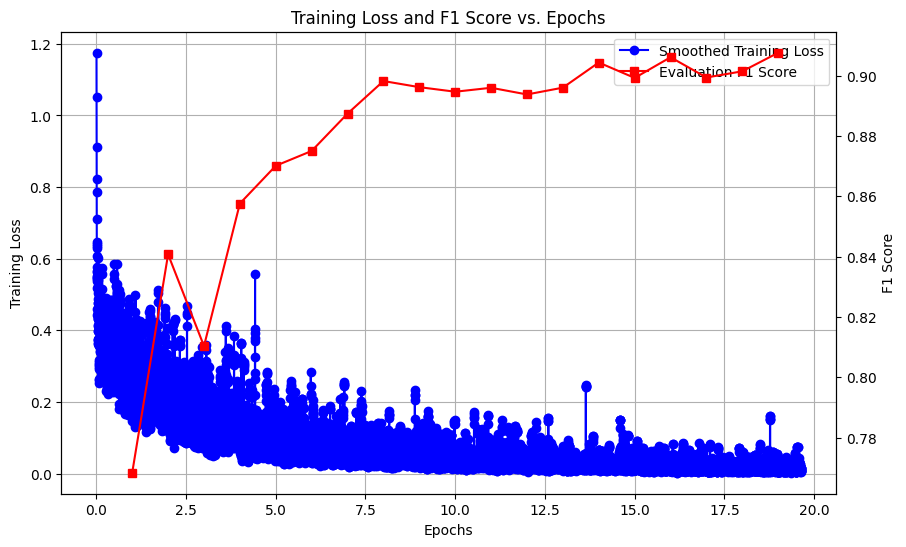

In [39]:
fig = visualise_training_history(trainer, 5)

#### Export model, training history, tokenizer & history

In [40]:
export_path = f"C:/Users/niels/PycharmProjects/BookReviewsThesis/models/{datetime.now().strftime('%Y-%m-%d_%H_%M')}/"
export_path

'C:/Users/niels/PycharmProjects/BookReviewsThesis/models/2024-05-09_16_53/'

In [41]:
os.makedirs(export_path, exist_ok=True)

In [42]:
trainer.save_model(export_path + "model")
tokenizer.save_pretrained(export_path + "tokenizer")

('C:/Users/niels/PycharmProjects/BookReviewsThesis/models/2024-05-09_16_53/tokenizer\\tokenizer_config.json',
 'C:/Users/niels/PycharmProjects/BookReviewsThesis/models/2024-05-09_16_53/tokenizer\\special_tokens_map.json',
 'C:/Users/niels/PycharmProjects/BookReviewsThesis/models/2024-05-09_16_53/tokenizer\\vocab.txt',
 'C:/Users/niels/PycharmProjects/BookReviewsThesis/models/2024-05-09_16_53/tokenizer\\added_tokens.json',
 'C:/Users/niels/PycharmProjects/BookReviewsThesis/models/2024-05-09_16_53/tokenizer\\tokenizer.json')

In [43]:
with open(export_path + "history.json", 'w') as file:
    json.dump(trainer.state.log_history, file, indent=4)
with open(export_path + "loss_training_history.json", 'w') as file:
    json.dump(trainer.loss_history, file, indent=4)
with open(export_path + "model_name.txt", 'w') as file:
    file.write(model_checkpoint)  # Writing the string to the file

In [44]:
# Save the training history plot to file
fig.savefig(export_path + "training_and_f1_plot.png")

#### Make and visualize predictions on unseen data

In [45]:
def merge_overlapping_intervals(intervals):
    merged_intervals = []
    if not intervals:
        return merged_intervals

    # Sort intervals based on the start value
    intervals.sort(key=lambda x: x[0])

    # Initialize variables for the first interval
    start, end, label = intervals[0]

    # Iterate through the intervals
    for interval in intervals[1:]:
        next_start, next_end, next_label = interval

        # If the intervals overlap, merge them
        if next_start <= end + 1:
            end = max(end, next_end)
        else:
            # If no overlap, add the merged interval to the result and update start, end, label
            merged_intervals.append((start, end, label))
            start, end, label = next_start, next_end, next_label

    # Add the last merged interval
    merged_intervals.append((start, end, "BOOK"))

    return merged_intervals

def visualize_output(output, text):
    spans = [(res['start'], res['end'], res['entity']) for res in output if res['entity'] == 'BOOK']
    spans = merge_overlapping_intervals(spans)

    nlp = spacy.blank('nl')
    doc = nlp.make_doc(text)
    ents = []
    for span_start, span_end, label in spans:
        ent = doc.char_span(span_start, span_end, label=label)
        if ent is None:
            continue
    
        ents.append(ent)
    
    doc.ents = ents
    displacy.render(doc, style="ent", jupyter=True)

In [46]:
pipe = pipeline(task="token-classification", model=model, tokenizer=tokenizer)

In [47]:
visualize_index = 25

In [48]:
validation_df = df_clean[df_clean['content'].isin(val_samples)]

In [49]:
output = pipe(validation_df.iloc[visualize_index]["content"].lower())

In [50]:
validation_df[validation_df['content'] == validation_df.iloc[visualize_index]["content"]].title4

150                                     malpertuis
151                          kalender voor de tuin
152                   — die theorie demokratischer
153                        sprookjes van de liefde
154                      vlinders tussen de stenen
155    -*• informatie in woord en beeld. weer zijn
Name: title4, dtype: object

In [51]:
visualize_output(output, validation_df.iloc[visualize_index]["content"])

#### Load model and tokenizer

In [ ]:
model_new = AutoModelForTokenClassification.from_pretrained(export_path + "model")
tokenizer_new = AutoTokenizer.from_pretrained(export_path + "tokenizer")

In [ ]:
pipe = pipeline(task="token-classification", model=model_new, tokenizer=tokenizer_new)

In [ ]:
sentence = remove_punctuation(df_clean['content'].unique()[0].lower())

In [ ]:
output = pipe(sentence)

In [ ]:
visualize_output(output, sentence)